<a href="https://colab.research.google.com/github/Parkseojin2001/Machine-Learning_with_python/blob/main/Chapter6_Algorithm-chains-and-pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter6 알고리즘 체인과 파이프라인

***Goal )***

- 데이터 변환 과정과 머신러닝 모델을 쉽게 연결해주는 Pipeline 파이썬 클래스를 설명

- Pipeline과 GridSearchCV를 함께 사용하여 각 처리 단계에서 필요한 매개변수 탐색을 동시에 수행

In [1]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 KB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=a0200163ab1bf4b95fff397c3086049361764675ef0e4a3df33feb504d00c77a
  Stored in directory: /root/.cache/pip/wheels/87/75/37/404e66d0c4bad150f101c9a0914b11a8eccc2681559936e7f7
Successfully built mglearn


In [2]:
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 10.9 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0


In [3]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 데이터를 분할하고 최솟값, 최댓값을 창아 데이터의 스케일을 바꾸고 SVM을 훈련
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

# 훈련 데이터의 최솟값, 최댓값을 계산
scaler = MinMaxScaler().fit(X_train)

In [5]:
# 훈련 데이터의 스케일을 조정
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


### 6.1 데이터 전처리와 매개변수 선택


In [6]:
# GridSearchCV를 사용해서 더 좋은 SVC 매개변수 찾기
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것임. 실제 사용 X
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid = param_grid, cv = 5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


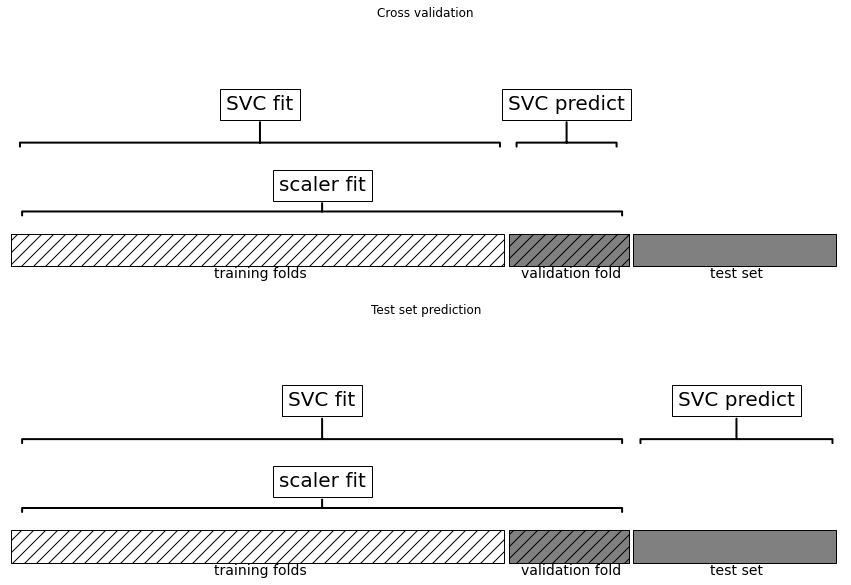

In [7]:
# 교차 검증 반복 밖에서 전처리가 될 때 데이터 사용 형태
mglearn.plots.plot_improper_processing()

**문제점**

- 데이터 스케일을 조정(데이터의 최솟값과 최댓값을 계산)할 때 검증 폴드에 들어 있는 정보까지 이미 사용 

- 교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때를 올바르게 반영하지 못함

- 검증 폴드 데이터의 정보가 모델 구축 과정에 이미 누설되어서 교차 검증에서 최적의 매개변수를 찾지 못함<br>
  &rarr; 낙관적인 결과가 만들어짐

**해결책**

- 교차 검증의 분할이 모든 전처리 과정보다 앞서 이루어져야 함

- 데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 훈련 부분에만 적용되어야 하므로 교차 검증 반복 안에 존재해야함

*&rarr; Pipeline을 이용 : 여러 처리 단계를 하나의 scikit-learn 추정기 형태로 묶어주는 파이썬 클래스*

## 6.2 파이프라인 구축하기

각 단계를 리스트로 전달하여 파이프라인 객체를 생성하며 추정기의 객체와 임의의 이름으로 구성된 튜플이다.

In [8]:
# 첫 번쨰 단계 : 데이터 스케일을 조정하는 객체 생성
# 두 번째 단계 : 훈련시킬 모델의 객체 생성
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [9]:
# pipe.fit : 첫 번쨰 단계(scaler)의 fit 메서드르 호출하여 훈련 데이터를 변환
# 변환된 데이터에 SVM 모델을 훈련
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [10]:
# sclaer를 사용하여 테스트 데이터를 변환
# 변환된 데이터에 SVM 모델의 score 메서드를 호출
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


## 6.3 그리드 서치에 파이프라인 적용하기

1) 탐색할 매개변수 그리드를 정의

2) 매개변수 그리드와 파이프라인으로 GridSearchCV의 객체를 형성

*단, 각 매개변수가 파이프 라인의 어떤 단계에 속한 것인지 알려줘야함*

- 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 "__"(밑줄 문자 2개)로 연결해 생성

In [11]:
param_grid = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}

In [12]:
# 매개변수 검색 과정에서 검증 폴드의 정보가 누설 X
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters:", grid.best_params_)

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


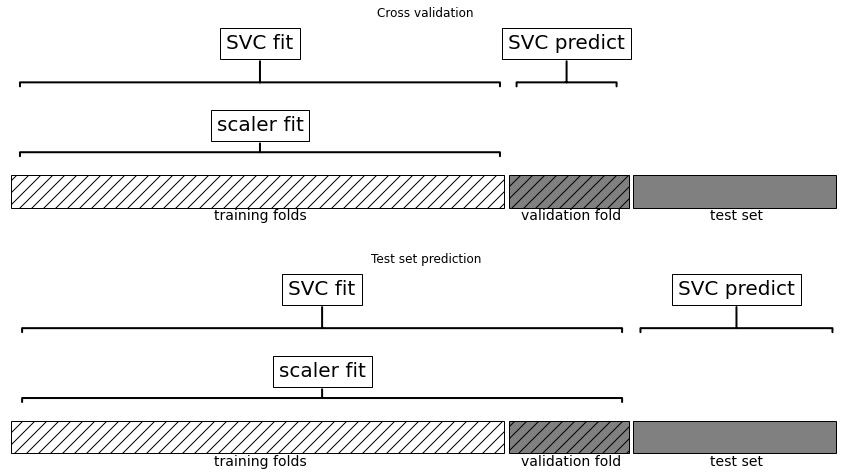

In [13]:
# 교차 검증 반복 안에서 전처리가 될 때 데이터 사용 형태
mglearn.plots.plot_proper_processing()

***정보 누설에 대한 예시***



In [14]:
# X, y 사이에는 아무런 관계가 없음(독립적)
rnd = np.random.RandomState(seed = 0)
X = rnd.normal(size = (100, 10000))
y = rnd.normal(size = (100,))

In [15]:
# SelectPercetile로 10,000개 중 가장 유용한 특성 선택
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func = f_regression, percentile = 5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape:", X_selected.shape)

X_selected.shape: (100, 500)


In [16]:
# 교차 검증을 사용하여 Ridge 회귀를 평가
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation score(Ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv = 5))))

Cross-validation score(Ridge): 0.91


In [17]:
# 파이프라인을 사용한 교차 검증과 비교
pipe = Pipeline([("select", SelectPercentile(score_func = f_regression, percentile = 5)), ("ridge", Ridge())])
print("Cross-validation score(pipeline): {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv = 5))))

Cross-validation score(pipeline): -0.25


**출력 결과 분석**

*Ridge*<br>
- 평균 R^2은 0.91이므로 좋은 모델임<br>
&rarr; 테스트 폴드에서 유출되어 비현실적으로 높은 결과가 출력

*PipeLine*<br>
* R^2 점수가 음수라 성능이 매우 낮은 모델임<br>
&rarr; 훈련 폴드를 사용해서만 특성이 선택되었고 테스트 폴드는 사용하지 않았다는 의미

***정보 누설을 막는 것이 모델의 성능을 평가하는 데 큰 차이를 만든다는 것을 알 수 있음***

## 6.4 파이프라인 인터페이스

Pipeline은 전처리나 분류에 국한하지 않고 어떤 추정기와도 연결할 수 있다.

ex)

1) 특성 추출

2) 특성 선택

3) 스케일 변경

4) 분류 or 회귀 or 군집

- 마지막 단계(4단계)를 제외하고는 모두 transform 메서트를 가지고 있음

*Pipeline.fit 메서드를 실행*

1) 파이프라인은 각 단계에서 이전 단계의 transform의 출력을 입력을 받아 fit과 transform 메서드를 차례로 호출

2) 마지막 단계는 fit 메서드만 호출


In [18]:
def fit(self, X, y):
  X_transformed = X
  for name, estimator in self.steps[:-1]:
    # 마지막 단계를 빼고 fit과 transform을 반복
    X_transformed = estimator.fit_transform(X_transformed, y)
  # 마지막 단계 fit을 호출
  self.steps[-1][1].fit(X_transformed, y)
  return self

In [19]:
def predict(self, X):
  X_transformed = X
  for step in self.steps[:-1]:
    # 마지막 단계를 빼고 transform을 반복
    X_transformed = step[1].transform(X_transformed)
  # 마지막 단계 predict을 호출
  return self.steps[-1][1].predict(X_transformed)

**파이프라인의 훈련과 예측의 과정**

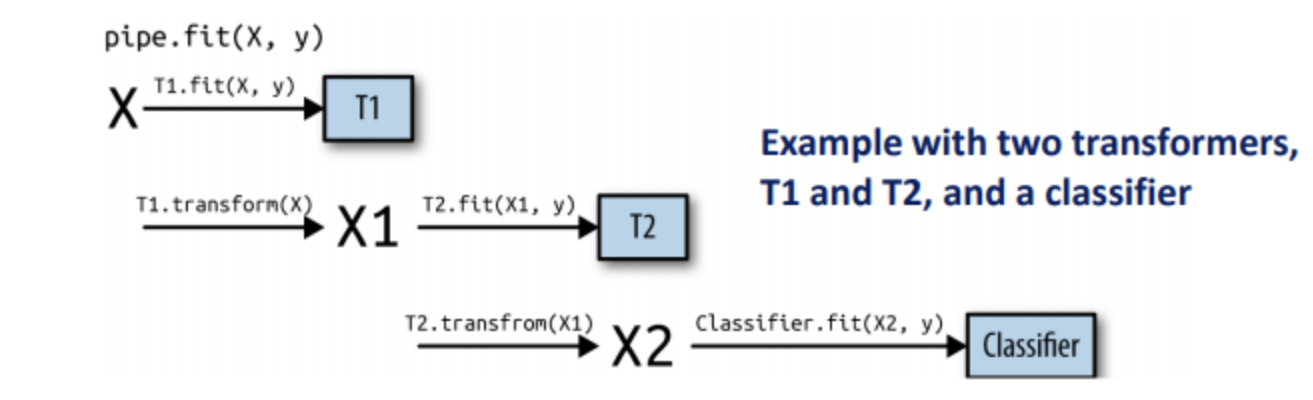
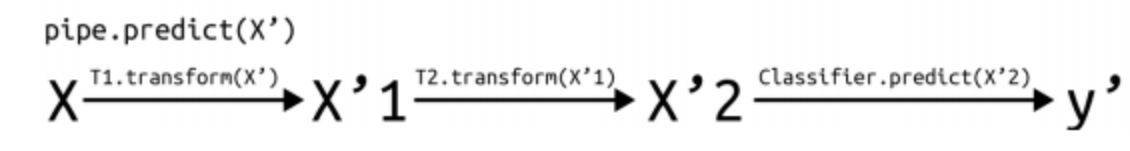

***NOTE_ 추정기 객체를 시각화***

set_config 함수의 display 매개변수를 기본값 'text'에서 'diagram'으로 바꾸어 준 추 파이프라인 객체를 출력할 수 있다.

In [20]:
# <정보 누설에 대한 예시 상자> 안에서 만든 pipe 객체의 구조를 출력
from sklearn import set_config

set_config(display = 'diagram')
pipe

Pipeline(steps=[('select',
                 SelectPercentile(percentile=5,
                                  score_func=<function f_regression at 0x7f296db26af0>)),
                ('ridge', Ridge())])

### 6.4.1 make_pipeline을 사용한 파이프라인 생성

make_pipeline 함수 : 각 단계 이름에 해당 파이썬 클래스의 이름을 부여한 파이프라인을 만들어준다.

In [21]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C = 100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C = 100))

In [22]:
# pipe_long과 pipe_short이 정확히 똑같은 작업을 수행하지만 pipe_short은 단계의 이름을 자동으로 생성
# steps 속성에 각 단계의 이름이 존재
print("Pipeline step:\n", pipe_short.steps)

Pipeline step:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


- 단계의 이름은 minmaxscaler와 svc이며 일반적으로 단계의 이름은 파이썬 클래스 이름의 소문자 버전으로 생성된다.

- 같은 파이썬 클래스를 여러 단계에서 사용하면 이름 뒤에 숫자가 추가

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components = 2), StandardScaler())
print("Pipeline step:\n", pipe.steps)

Pipeline step:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### 6.4.2 단계 속성에 접근하기

파이프라인의 단계 중 하나의 속성을 확인하고 싶을 때 사용.

ex ) 선형 모델의 계수나 PCA에서 추출한 주성분 확인

방법 : 단계 이름을 키로 가진 딕션너리인 named_steps 속성을 사용하면 파이프라인의 각 단계에 쉽게 접근이 할 수 있음

In [24]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


### 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기

파이프라인을 사용하는 주된 목적은 그리드 서치때문이며 그리드 서치 안에 있는 파이프라인의 단계에 접근할 때가 많다.

In [25]:
# make_pipeline 함수로 파이프라인을 생성
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000))

In [26]:
# 매개변수 그리드 생성
# LogisticRegression의 규제를 조절하는 매개변수 : C
param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10, 100]}

In [27]:
# 데이터셋을 훈련 세트와 테스트 세트로 나누고 그리드 서치 적용
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [28]:
# GridSearchCV로 최적의 모델을 찾은 후 전체 훈련 데이터로 학습한 모델이 grid.best_estimator_에 저장
print("Best model:\n", grid.best_estimator_)

Best model:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


**최적의 모델**

standardscaler와 logisticregression 두 단계를 가진 파이프라인이다.

In [29]:
# logisticregression 단계에 접근하는 방법 : 파이프라인의 named_steps 속성을 사용
print("LogisticRegression step:\n", grid.best_estimator_.named_steps["logisticregression"])

LogisticRegression step:
 LogisticRegression(C=1, max_iter=1000)


In [30]:
# 각 입력 특성에 연결된 계수(가중치)를 출력
print("LogisticRegression coef:\n", grid.best_estimator_.named_steps["logisticregression"].coef_)

LogisticRegression coef:
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


## 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

**파이프라인의 장점**

- 머신러닝 워크플로에 필요한 모든 처리 단계를 하나의 scikit-learn 추정기로 캡슐화 가능

- 회귀와 분류 같은 지도 학습의 출력을 이용해서 전처리 매개변수를 조정

*ex ) 다항식 특성을 선택해 리지 회귀에 적용*

1) 데이터 스케일 조정

2) 다항식 특성 선택

3) 리지 회귀

In [31]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [32]:
# alpha 매개변수 + degree 매개변수 탐색 -> param_grid 정의
param_grid = {'polynomialfeatures__degree' : [1, 2, 3], 'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]}

In [33]:
# 그리드 서치 적용
grid = GridSearchCV(pipe, param_grid = param_grid ,cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

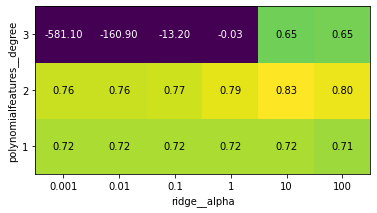

In [34]:
# 다항식 차수와 Ridge의 alpha 매개변수에 따른 교차 검증 평균 점수의 히트맵
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel = "ridge__alpha", ylabel = "polynomialfeatures__degree",
                      xticklabels = param_grid['ridge__alpha'],
                      yticklabels = param_grid['polynomialfeatures__degree'], vmin = 0)
plt.show()

**히트맵 분석**

- 2차항이 가장 효과가 좋음

- 3차항은 1, 2차항보다 결과가 나쁨

In [35]:
print("Best parameters:", grid.best_params_)

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [36]:
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

Test set score: 0.77


In [37]:
# 다항식 특성이 없는 그리드 서치와 비교
param_grid = {'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


- 모델의 매개변수와 함께 전처리 과정의 매개변수를 찾는 것은 매우 강력한 전략임

- GridSearchCV는 지정한 매개변수의 모든 가능한 조합을 가능하게 하므로 매개변수 그리드에 많은 매개변수를 추가하면 만들어야할 모델이 급격히 증가한다.

## 6.6 모델 선택을 위한 그리드 서치

파이프라인을 구성하는 단계도 탐색 대상으로 삼을 수 있음.

ex ) StandardScaler와 MinMaxScaler 중 어떤 것을 사용해야하는지 선택하는 경우

*if ) cancer 데이터셋에서 RandomForestClassifier와 SVC를 비교*

- SVC는 데이터의 스케일을 조정해야 하므로 StandardScaler를 사용할지 또는 전처리를 하지 않을지 판단

- RandomForestClassifier에는 전처리 필요 X



In [38]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [39]:
# 검색할 parameter_grid를 정의
# classifier는 RandomForestClassifier나 SVC가 되어야함
# 매개변수 그리드의 리스트를 사용(두 모델의 매개변수와 전처리에 차이가 있음)
# 해당 단계인지 지정 : 추정기 단계의 이름을 매개변수 이름으로 사용
# 전치리 필요 X : None을 할당 
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
     {'classifier': [RandomForestClassifier(n_estimators = 100)],
      'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}
]

In [40]:
# 그리드 서치 객체 생성
# cancer 데이터셋으로 실행
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Best parameters\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test set score: 0.98


### 6.6.1 중복 계산 피하기

대규모 그리드 서치를 수행할 때 종종 동일한 단계가 여러 번 수행

**문제점**

- 비용이 많이 드는 변환(PCA나 NMF를 사용한 특성 추출)을 사용한다면 계산 낭비가 심해짐

**해결책**

- memory 매개변수를 사용하여 계산 결과를 캐싱하는 것

- memory 매개변수는 joblib.Memory 객체나 캐싱할 경로를 받음

In [41]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory = "cache_folder")

**단점**

- 캐시는 디스크에 저장되어 관리되기 때문에 실제 디스크에 읽고 쓰기 위해 직렬화(serialization)가 필요 = 비교적 오랜 시간이 걸리는 변환이어야 효과가 있음

- n_jobs 매개변수가 캐싱을 방해<br>
  &rarr; 그리드 서치의 실행 순서에 따라 최악의 경우 캐시되기 전에 n_jobs만큼의 작업 프로세스가 동시에 동일한 계산을 중복으로 수행될 수 있음

**해결책**

- dask-ml 라이브러리에서 제공하는 GridSearchCV를 사용

  - dask-ml은 병렬 연산을 수행하는 동안 중복된 계산을 방지

  - 클러스터에 분산된 경우에도 가능

  - 계산 비용이 높은 파이프라인과 방대한 양의 매개변수 탐색할 때 유용

## 6.7 요약과 정리